Author: Max Matthews and Frinze Erin Lapuz (22711649)

This is the IPython Jupyter Notebook for generating the PDF report, documentation, and generating the staging_data.

To generate html, pdf and tex file, run the following command `generate_report.bat` in the command line. You may need to have Anaconda activated, Jupyter NBconvert, and LaTex renderer (eg. MikTex) in your environment to do this.


# Introduction

For this project, we would like to use the mobile price classification dataset as the source of data. The target of this project is to predict whether the price of a mobile phone is high or not.


## Tasks and Scope

### 1) Data cleaning and analysis

  - Read through the table and the table column descriptions. Understand the meaning of each column in the table.
  - Distinguish the type of each attribute (e.g., nominal/categorical, numerical). You may need to discretise some attributes, when completing Task 2, 3 or 4.
  - Determine whether an attribute is relevant to your target variable. You may remove some attributes if they are not helpful for Task 2, 3, or 4. You might create separate data files for Task 2, 3 and 4.
  - Identify inconsistent data and take actions using the knowledge you have learnt in this unit.

### 2) Association rule mining
  - Select a subset of the attributes (or all the attributes) to mine interesting patterns. To rank the degree of interesting of the rules extracted, use support, confidence and lift.
  - Explain the top k rules (according to lift or confidence) that have the "price_category” on the right-hand-side, where k >= 1.
  - Explain the meaning of the k rules in plain English.
  - Given the rules, what recommendation will you give to a company willing to design a high price mobile phone (e.g., should the mobile phone equipped with bluetooth)?

### 3) Classification
  - Use the "price_category" as the target variable and train two classifiers based on different machine learning algorithms (e.g. classifier 1 based on a decision tree; classifier 2 based on SVMs).
  - Evaluate the classifiers based on some evaluation metrics (e.g., accuracy). You may use 10-fold cross-validation for the evaluation.

### 4) Clustering
  - Run a clustering algorithm of your choice and explain how the results can be interpreted with respect to the target variable.

### 5) Data reduction
  - Perform numerosity reduction and perform attribute reduction.
  - Train the two classifiers in Task 3 on the reduced data.
  - Answer the question: "Does data reduction improve the quality of the classifiers"?

### 6) Attribute selection
  - Select the top-10 most important attributes manually based on your understanding of the problem; select the top-10 most important attributes based on Information Gain.
  - Which attribute selection method is better and why?


## **Marking Scheme**
[5 marks]   Explain the data processing operations (e.g., remove some attributes and action on inconsistent data) that you have done.

[5 marks]   Explain and interpret the top k association rules mined; based on the association rules, provide a recommendation for a company willing 
            to design a high price mobile phone.
            
[5 marks]   Explain how you train the classifiers and your evaluation results.

[5 marks]   Clustering and interpretation of the clustering result (with respect to the target variable).

[5 marks]   Explain the data reduction you have performed; compare the classifiers trained on reduced data with the classifiers trained on the original data.

[5 marks]   Your answer to Task 6.

## Tools, Libraries and Packages

Python - Used throughout the project for data cleaning, data processing, and modelling.

### Imports

https://graphviz.org/download/

In [1]:
pip install pandas-profiling[notebook] mlxtend clusteval pca graphviz dtreeviz tabulate --user

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Data analysis, manipulation, and profiling
import pandas as pd
pd.options.display.max_colwidth = 100
pd.set_option("display.notebook_repr_html", False)

import numpy as np
from pandas_profiling import ProfileReport

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# Association Rule Mining
from mlxtend.frequent_patterns import apriori, association_rules

# Training Setups
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Preprocessings and Attribute Selections
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# selection of best attributes from by default using f-score https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

# Classifiers
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC # Support Vector Machine Classifier
from sklearn import tree
import graphviz
from dtreeviz.trees import dtreeviz 

RANDOM_STATE = 1 # Used as a seed value
CROSS_VALIDATION_PARTITION = 10
NUMBER_OF_BEST_HYPER_PARAMS_TO_SHOW = 5

# Optimisation
from sklearn.model_selection import GridSearchCV # tuning the model
from sklearn.model_selection import cross_val_score, cross_validate

# Clustering
from clusteval import clusteval
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram

# Data Reduction
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN
from pca import pca


In [ ]:
from IPython.display import Markdown, display
def display_markdown(dataframe):
    display(Markdown(dataframe.to_markdown()))

<br >

# Data Cleaning and Profiling

There are many ways to approach a project's data cleaning, and data profiling steps. For these processes (in Project 2) we will be using an IPython Notebook, for the following reasons:

- Both group members are proficient in Python;
- The report can be integrated with code for specific sections of the analysis;
- The processes / procedures are highly repeatable and easily automated using scripts;
- Data exploration and anomaly detection can easily be performed through a variety of visualizations (charts, graphs, tables, etc);

The packages that will be used are built in to the default Anaconda package, with exception to `pandas_profiling`, `mlxtend`, and `pca`.

- `pandas_profiling` (from https://github.com/pandas-profiling/pandas-profiling) was leveraged to provide a detailed exploratory analysis of our data, and the attributes we would be working with.  Data profiling is crucial to the measurement of the quality of data, which in turn greatly assists the analyst team in their discovery of data anomalies/inconsistencies, and as such, appropriate data transformations and/or pre-processing actions. The data-profiling reports (generated by this package) will be referenced in our project discussion, with the full resource located in the appendix.

- `mlxtend` (from https://github.com/rasbt/mlxtend) was used in our Association Rule Mining section, to assist in the mining of such associated rules.  

- `pca` (from https://github.com/erdogant/pca) was used for graphical presentation of the Principal Component Analysis.

In [3]:
raw_data = pd.read_csv("./data/raw/mobile_price.csv")
raw_metadata = pd.read_excel("./data/raw/ColumnDescription.xlsx", index_col="Column")

raw_data

        id  battery_power blue  clock_speed dual_sim  fc  four_g  int_memory  \
0        0            842   no          2.2       no   1       0           7   
1        1           1021  yes          0.5      YES   0       1          53   
2        2            563  yes          0.5      Yes   2       1          41   
3        3            615  has          2.5       no   0       0          10   
4        4           1821  yes          1.2       NO  13       1          44   
...    ...            ...  ...          ...      ...  ..     ...         ...   
1995  1995            794  yes          0.5      yes   0       1           2   
1996  1996           1965  yes          2.6      yes   0       0          39   
1997  1997           1911   no          0.9      yes   1       1          36   
1998  1998           1512   no          0.9      not   4       1          46   
1999  1999            510  Yes          2.0      yes   5       1          45   

      m_dep  mobile_wt  ...  px_height 

In [4]:
raw_metadata.to_dict()["Explaination"]

{'id': 'ID',
 'battery_power': 'Total energy a battery can store in one time measured in mAh',
 'blue': 'Has bluetooth or not',
 'clock_speed': 'speed at which microprocessor executes instructions',
 'dual_sim': 'Has dual sim support or not',
 'fc': 'Front Camera mega pixels ',
 'four_g': 'Has 4G or not. 1 = yes , 0 = no',
 'int_memory': 'internal Memory in Gigabytes',
 'm_dep': 'Mobile Depth in cm',
 'mobile_wt': 'Weight of mobile phone',
 'n_cores': 'Number of cores of processor',
 'pc': 'Primary Camera mega pixels',
 'px_height': 'Pixel Resolution Height',
 'px_width': 'Pixel Resolution Width',
 'ram': 'Random Access Memory in Mega Bytes',
 'sc_h': 'Screen Height of mobile in cm',
 'sc_w': 'Screen Width of mobile in cm',
 'talk_time': 'longest time that a single battery charge will last when you are',
 'three_g': 'Has 3G or not',
 'touch_screen': 'Has touch screen or not, 1 = yes, 0 = no',
 'wifi': 'Has wifi or not',
 'price_category': 'This is the target variable with indicating if

## Profiling Report

With the imported metadata, and raw dataset, we can now populate and generate a `pandas_profiling` report. For reference, see `Raw Data Profiling Report`, in the apendix.

## Raw Data - Interpretation, Analysis, and Cleaning 

Here, we will walk through the fields presented in the raw data, stating assumptions/decisions, and  undertaking any appropriate cleaning steps.  In the event of changes, we will apply them to the `staging_data` data frame, and `staging_metadata` dictionary.

In [5]:
# Clone the raw data & metadata 
staging_data = raw_data.copy()
staging_metadata = raw_metadata.copy()

# By default the new_name is the old_name
staging_metadata["new_name"] = staging_metadata.index

In [6]:
# helper functions
    
def string_to_bool(value):
    """
    Converts String representation of Boolean ("yes", "has")/("no","not") to True/False
    """
    if value.lower() in ["yes","has"]:
        return True
    elif value.lower() in ["no","not"]:
        return False
    return None


def int_to_bool(value):
    """
    Converts int representation of Boolean (1, 0) to True/False
    """
    return value == 1


def create_discretised_col(df, target_col, new_col_name=None, is_zero_its_own_category=True):
    """
    This function discretises the column
    """
    # Default value of new col
    if new_col_name is None:
        new_col_name = f"{target_col}_category"
        
    col_holder = df[target_col]
    df[new_col_name] = 0 # Initialise
    
    if is_zero_its_own_category:
        df.loc[col_holder>0, new_col_name] = pd.cut(col_holder[col_holder>0],bins=4,include_lowest=True)
    else:
        df.loc[:, new_col_name] = pd.cut(col_holder,bins=4,include_lowest=True)
    
    return df


_____
#### `ID`
The id field is unique, and it seems to be a good candidate for primary key.  Note, we will NOT be using ID for any analysis, as it is an irrelevant attribute.


_______
#### `battery_power`
The battery_power has 1094 distinct counts, approximately half the distinct counts of id.  This data is continuous, and as such, we shall discretise for the later association rule mining.

In [7]:
staging_data = create_discretised_col(staging_data, "battery_power", is_zero_its_own_category = False)

________

#### `blue`
This ("has bluetooth") field is a categorical data type (*boolean*), expressed (poorly) in string-form, with many inconsistencies.  We observe 10 distinct values that all refer to either the phone having bluetooth (True), or not having bluetooth (False). The inconsistencies must be attributed to an appropriate boolean value, and as such, this field needs to be cleaned.

In [8]:
staging_data["has_bluetooth"] = staging_data["blue"].apply(string_to_bool)
staging_metadata.loc["blue","new_name"] = "has_bluetooth"  # Rename metadata

_____
#### `clock_speed`
The clock_speed attribute has 26 distinct values for which 413 of the records have a value of 0.5. We note that the distribution of values in the histogram is right skewed.  This data is continuous and will need to be discretised if we wish to use it in the association rule mining process.

In [9]:
staging_data = create_discretised_col(staging_data, "clock_speed", is_zero_its_own_category = False)

_____
#### `dual_sim`
The dual_sim attirbute is similar to the `blue` / `has_bluetooth` attribute, wherein it is a categorical datatype (*boolean*) with its inconsistencies forming 10 (*string*) distinct values. Hence, the procedure of cleaning will be similar.

In [10]:
staging_data["has_dual_sim"] = staging_data["dual_sim"].apply(string_to_bool)
staging_metadata.loc["dual_sim","new_name"] = "has_dual_sim"  # Rename metadata

___
#### `fc`
The (*Front Camera*) `fc` attribute has 474 (23.7% of the dataset) zero values.  We will be interpreting the zero values as "this phone does not have a front camera" (please see the ***Data Privacy Disclaimer*** below).  This continous data will be discretised for later (association rule mining) purposes, with present zero values (as a result of our domain interpretation) populating their own level within this category.

In [11]:
staging_data["front_cam_resolution"] = staging_data["fc"]
staging_metadata.loc["fc","new_name"] = "front_cam_resolution" # Rename metadata
staging_data = create_discretised_col(staging_data, "front_cam_resolution", is_zero_its_own_category = True)

___
#### `four_g`
The `four_g` attribute is a categorical (*boolean*) attribute, with values indicated as `yes = 1` and `no = 0` regarding (the phone's) 4G capability. For consistency, this will be converted from current numeric form to boolean type.

In [12]:
staging_data["has_four_g"] = staging_data["four_g"].apply(int_to_bool)
staging_metadata.loc["four_g","new_name"] = "has_four_g" # Rename metadata

_______



#### `int_memory`
The `int_memory` (*Internal Memory*) attribute has 63 distinct values that vary as shown in the *profiling-report* histogram.  There are no records of phones having `0 GB` as the storage which would be expected, as phones would require a minimum amount of memory to host their respective operating software/s.  This continuous data will be discretised for later use in the association rule mining phase.

In [13]:
staging_data = create_discretised_col(staging_data, "int_memory", is_zero_its_own_category = False)

____________

#### `m_dep`
The `m_dep` (*Mobile Depth*) attribute has 10 distinct values that vary as shown in the *profiling-report* histogram. The minimum values do not make much sense, however, please refer to the ***Data Privacy Disclaimer*** below.  Additionally, this continuous data will be discretised for later (association rule mining) purposes.

In [14]:
staging_data["mobile_depth"] = staging_data["m_dep"]
staging_metadata.loc["m_dep","new_name"] = "mobile_depth"  # Rename metadata
staging_data = create_discretised_col(staging_data, "mobile_depth", is_zero_its_own_category = False)

______________
#### `mobile_wt`
The `mobile_wt` (*Mobile Weight*) attribute has 121 distinct values that vary as shown in the *profiling-report* histogram. The respective min and max values are `80` and `200`, measured in presumably grams.  This continuous data will be discritised for later association rule mining purposes.

In [15]:
staging_data["mobile_weight"] = staging_data["mobile_wt"] 
staging_metadata.loc["mobile_wt","new_name"] = "mobile_weight" # Rename metadata
staging_data = create_discretised_col(staging_data, "mobile_weight", is_zero_its_own_category = False)

________
#### `n_cores`
The `n_cores` (*Number of Cores*) attribute looks almost uniform in the range `1-8`. This is categorical (numerical) data, and requires no further attention at this moment.

In [16]:
staging_data["number_of_cores"] = staging_data["n_cores"]
staging_metadata.loc["n_cores","new_name"] = "number_of_cores" # Rename metadata

________________
#### `pc`
The `pc` (*Primary Camera Resolution*) attribute displays 21 distinct values, with 101 zero values (5.1% of the data). We will be interpreting the zero values as "this phone does not have a primary camera", (please see the ***Data Privacy Disclaimer*** below). This continuous data will be discretised for later (association rule mining) purposes, with present zero values (as a result of our domain interpretation) populating their own level within this category.

In [17]:
staging_data["primary_cam_resolution"] = staging_data["pc"]
staging_metadata.loc["pc","new_name"] = "primary_cam_resolution"
staging_data = create_discretised_col(staging_data, "primary_cam_resolution", is_zero_its_own_category = True)

_____
#### `px_height`
The `px_height` (*Pixel Height*) attribute has a right-skewed, normal distribution, with a mean and standard deviation of `645` and `443.79` pixels (respectively), and values falling in the range `0-1960`.  We will be interpreting the two zero values as *extremely small, but not zero* values, (please see the ***Data Privacy Disclaimer*** below).  This notion also applies to the nonsensical low values.  For association rule mining purposes, this continuous data will be discretised, wherein (as per the assumption above) the zero values will fall within the first category, shared by other values (relatively) close to zero.

In [18]:
staging_data = create_discretised_col(staging_data, "px_height", is_zero_its_own_category = False)

______
#### `px_width`
The `px_width` (*Pixel Width*) attribute has a varying distribution of values in the range 500 to 1998. This continuous data will be discretised, for later (association rule mining) purposes.

In [19]:
staging_data = create_discretised_col(staging_data, "px_width", is_zero_its_own_category = False)

_____
#### `ram`
The `ram` attribute has a varying distribution of values in the range `256-3998`. This continuous data will be discretised, for later (association rule mining) purposes.

In [20]:
# Discretizing ram
staging_data = create_discretised_col(staging_data, "ram", is_zero_its_own_category = False)

_____
#### `sc_h`
The `sc_h` (*Screen Height*) attributes has 15 distinct values with a range of `5-19`. This continuous data will be discretised, for later (association rule mining) purposes.

In [21]:
staging_data["screen_height"] = staging_data["sc_h"]
staging_metadata.loc["sc_h","new_name"] = "screen_height" # Rename metadata
staging_data = create_discretised_col(staging_data, "screen_height", is_zero_its_own_category = False)

______________
#### `sc_w`
The `sc_w` (*Screen Width*) attribute has 19 distinct values with a range of `0-18` with 180 zero values. These zero values do not make *real world sense*, and so we will be interpreting any zero values as representatives of sensible, low values (please see the ***Data Privacy Disclaimer*** below). Note that this notion also applies to any non-zero, nonsensical low values.  For association rule mining purposes, this continuous data will be discretised, wherein (as per the assumption above) the zero values will fall within the first category, shared by other values (relatively) close to zero.

In [22]:
staging_data["screen_width"] = staging_data["sc_w"]
staging_metadata.loc["sc_w","new_name"] = "screen_width" # Rename metadata
staging_data = create_discretised_col(staging_data, "screen_width", is_zero_its_own_category = False)

______
#### `talk_time`
The `talk_time` attribute has 19 distinct values with a range `2-20`. This continuous data will be discretised, for later (association rule mining) purposes.

In [23]:
staging_data = create_discretised_col(staging_data, "talk_time", is_zero_its_own_category = False)

_______
#### `three_g`
The `three_g` attribute is similar to the `has_bluetooth` and `dual_sim` attribute, wherein it is a categorical (*boolean*) datatype, with inconsistencies spread to 10 (string) distinct values.  As such, the cleaning procedure will be similar.

In [24]:
staging_data["has_three_g"] = staging_data["three_g"].apply(string_to_bool)
staging_metadata.loc["three_g","new_name"] = "has_three_g" # Rename metadata

_____
#### `touch_screen`
The `touch_screen` attribute is a categorical (*boolean*) attribute, similar to the initial state of the imported `four_g` attribute.  Hence, the cleaning procedure is similar.

In [25]:
staging_data["has_touch_screen"] = staging_data["touch_screen"].apply(int_to_bool)
staging_metadata.loc["touch_screen","new_name"] = "has_touch_screen" # Rename metadata

_____
#### `wifi`
The `wifi` (*has wifi*) attribute is similar to `blue`,`dual_sim` and `three_g` attribute, wherein it is a boolean datatype with inconsistencies spread to 10 (string) distinct values. Hence, the procedure of cleaning will be similar.

In [26]:
staging_data["has_wifi"] = staging_data["wifi"].apply(string_to_bool)
staging_metadata.loc["wifi","new_name"] = "has_wifi" # Rename metadata

________
#### `price_category`
The `price_category` attribute is categorical (*boolean*) data, similar to the representation of `four_g` and `touch_screen`. Hence, the cleaning procedure is similar.

In [27]:
staging_data["is_expensive"] = staging_data["price_category"].apply(int_to_bool)
staging_metadata.loc["price_category","new_name"] = "is_expensive" # Rename metadata

__________

## ***Data Privacy Disclaimer***

The data provided (`mobile_prices.csv`) has had some of it's *real world* values altered for privacy and/or legal reasons.  As such, decisions were made on how to best interpret unusual / nonsensical values equal, or approximately equal to `zero`.


### **Appropriate zero values**
- `primary_camera_resolution`
- `front_camera_resolution`

Zero values for these attributes can be observed as the phone not having the attribute. This makes sense, as not all phones have a front camera, or primary camera.


### Inappropriate zero values
- `px_height` 
- `screen_width`

Zero / close to zero values for these attributes can be observed as **values altered for privacy reasons** and should be interpreted as a representation of a relatively low value (but **NOT** taken literally as the stated value).


## Set `cleaned_data` and `discretised_data`

- Declare our `cleaned_data`, `discretised_data` and `cleaned_metadata`;
- Generate "clean" pandas-profiling report;
- Export these to `.csv` files;

In [28]:
cleaned_data = staging_data[[
    "id","battery_power","has_bluetooth","clock_speed",
    "has_dual_sim","front_cam_resolution","has_four_g",
    "int_memory","mobile_depth","mobile_weight",
    "number_of_cores", "primary_cam_resolution", "px_height",
    "px_width", "ram", "screen_height","screen_width", "talk_time", 
    "has_three_g","has_touch_screen", "has_wifi", "is_expensive"]]

discretised_data = staging_data[[
    "battery_power_category","has_bluetooth","clock_speed_category",
    "has_dual_sim","front_cam_resolution_category", "has_four_g",
    "int_memory_category","mobile_depth_category","mobile_weight_category",
    "number_of_cores", "primary_cam_resolution_category", "px_height_category",
    "px_width_category", "ram_category", "screen_height_category",
    "screen_width_category", "talk_time_category", "has_three_g",
    "has_touch_screen", "has_wifi", "is_expensive"]]

In [29]:
# Cleaned metadata
cleaned_metadata = staging_metadata.set_index("new_name")
cleaned_metadata_dict = cleaned_metadata.to_dict()["Explaination"]
cleaned_metadata

                                                                                                             Explaination
new_name                                                                                                                 
id                                                                                                                     ID
battery_power                                                Total energy a battery can store in one time measured in mAh
has_bluetooth                                                                                        Has bluetooth or not
clock_speed                                                           speed at which microprocessor executes instructions
has_dual_sim                                                                                  Has dual sim support or not
front_cam_resolution                                                                            Front Camera mega pixels 
has_four_g              

In [30]:
cleaned_data.to_csv("./data/cleaned/mobile_price.csv",index=False) # Export cleaned_data
discretised_data.to_csv("./data/cleaned/mobile_price_discretised.csv",index=False) # Export discretised_data

<br />

### Pandas-Profiling (`cleaned_data` and `discretised_data`) Reports

See `Clean Data Profiling Report`, and `Discretised Data Profiling Report` (in appendix).

In [31]:
# Sort all the columns based on value (this will determine the Ordinal Encoder)

discretised_ordered_data = discretised_data.copy()

for column in discretised_data.columns:
    if column != 'is_expensive':
        unique_sorted_values =np.sort(np.unique(discretised_data[column].astype(str)))
        dictionary = {}
        for numeric_value in range(len(unique_sorted_values)):
            dictionary[unique_sorted_values[numeric_value]] = numeric_value
        discretised_ordered_data[column] = discretised_data[column].apply(lambda value: dictionary[str(value)])
    
discretised_ordered_data

     battery_power_category  has_bluetooth clock_speed_category  has_dual_sim  \
0                         2              0                    2             0   
1                         3              1                    0             1   
2                         2              1                    0             1   
3                         2              1                    3             0   
4                         1              1                    1             0   
...                     ...            ...                  ...           ...   
1995                      2              1                    0             1   
1996                      1              1                    3             1   
1997                      1              0                    0             1   
1998                      0              0                    0             0   
1999                      2              1                    2             1   

      front_cam_resolution_

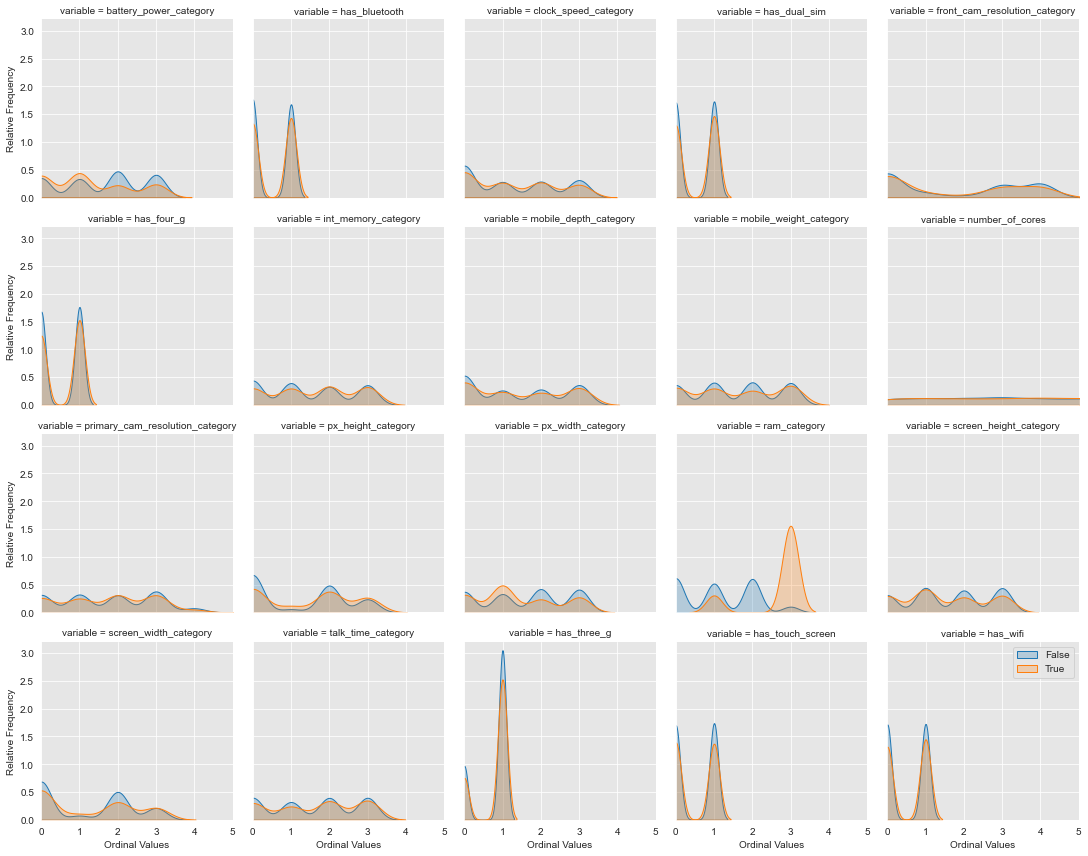

In [32]:
melted_data = pd.melt(discretised_ordered_data, "is_expensive", discretised_ordered_data.drop(["is_expensive"],axis="columns"), value_name="Ordinal Value",)

g = sns.FacetGrid(melted_data, col="variable", hue="is_expensive", col_wrap=5)
g.map(sns.kdeplot, "Ordinal Value", shade=True)
g.set_axis_labels("Ordinal Values", "Relative Frequency")

plt.xlim(0,5)
plt.legend()
plt.show()

This (above) shows the relative frequency graph of the discretised data, in ordinal form, split by the phone-data's `is_expensive` field.  The variable `ram_category` displays a strong variance regarding its seperation with `is_expensive`, which following steps will investigate further.

# Association Rule Mining


## Information

Association rule mining ('ARM') is a technique used investigate and uncover frequently occurring patterns, correlations, or associations, between the characteristics of a given dataset/s or source.  Association rules comprise of two parts:

-	antecedent (if) → An antecedent is something that is found in data;
-	consequent (then) → A consequent is an item that is found in combination with the antecedent.

## ARM Approach

Our approach is to take the characteristics of each of the phone attributes (from our data) with the following strategy:

- keep the (current) cleaned data, especially the boolean values;
- discretise any numeric values;


Before the "apriori" runs, the data should be in a form similar to:

|has_bluetooth|has_dual_sim|battery_power_0-100|...|
|---	|---	|---	|---	|
|True|False|True|True|
|True|True|False|True|
|False|True|True|False|

*For completed pre-processing, see IPython Notebook or* `./data/cleaned/ARM_item_characteristics.csv`

In [33]:
# restructuring cleaned_data for association rule mining
ARM_data = discretised_data

# Boolean Tables
ARM_structured_data = ARM_data.copy()[[item[0] for item in zip(ARM_data.columns,ARM_data.dtypes) if item[1] == np.bool]]

# Discretise data
non_boolean_values = ARM_data[[item[0] for item in zip(ARM_data.columns,ARM_data.dtypes) if item[1] != np.bool]]

# Adding extra columns from discretise data into columns
for non_boolean_column in non_boolean_values.columns:
    unique_values_in_column = ARM_data[non_boolean_column].unique()
    for category_name in unique_values_in_column:
        
        # Assign true if the current category name matches the data
        ARM_structured_data[f"{non_boolean_column}_{category_name}"] = ARM_data[non_boolean_column]==category_name
        
ARM_structured_data.head(3)

   has_bluetooth  has_dual_sim  has_four_g  has_three_g  has_touch_screen  \
0          False         False       False        False             False   
1           True          True        True         True              True   
2           True          True        True         True              True   

   has_wifi  is_expensive  battery_power_category_(499.502, 875.25]  \
0      True         False                                      True   
1     False         False                                     False   
2     False         False                                      True   

   battery_power_category_(875.25, 1249.5]  \
0                                    False   
1                                     True   
2                                    False   

   battery_power_category_(1623.75, 1998.0]  ...  \
0                                     False  ...   
1                                     False  ...   
2                                     False  ...   

   screen_he

In [34]:
ARM_structured_data.to_csv("./data/cleaned/ARM_item_characteristics.csv", index=False) # export to csv

## Apriori Algorithm

Apriori (*Apriori Algorithm*) is an algorithm used in frequent-item-set / pattern mining over relational datasets. It seeks to identify frequent, individual items in the data, and then extend them to (incrementally) larger item sets, on the proviso that such item sets appear sufficiently often enough in said data.


## Support

The recognition of frequently occurring patterns (in a dataset) must first be tuned by certain analyst-defined parameters.  The minimum support acts as an 'entry requirement value' that rules must meet/exceed, for them to be considered 'frequent'.  A minimum support value set too low, will not filter out patterns.  If it is set too high, this strict program's mining expedition will return no rules, or only extremely dominant attribute-patterns.  Example below, where we set `MINIMUM_SUPPORT = 0.1`, and then begin to mine the associated rules.

### Rules by 'Minimum Support'

In [36]:
# This defines what is considered as a minimum item
MINIMUM_SUPPORT = 0.1
frequent_items = apriori(ARM_structured_data,min_support=MINIMUM_SUPPORT,use_colnames=True, verbose=True)
display_markdown(frequent_items.head(5).append(frequent_items.tail(5)))

Processing 570 combinations | Sampling itemset size 5 4


|     |   support | itemsets                                                                                                                                  |
|----:|----------:|:------------------------------------------------------------------------------------------------------------------------------------------|
|   0 |    0.495  | frozenset({'has_bluetooth'})                                                                                                              |
|   1 |    0.5095 | frozenset({'has_dual_sim'})                                                                                                               |
|   2 |    0.5215 | frozenset({'has_four_g'})                                                                                                                 |
|   3 |    0.7615 | frozenset({'has_three_g'})                                                                                                                |
|   4 |    0.503  | frozenset({'has_touch_screen'})                                                                                                           |
| 712 |    0.1165 | frozenset({'has_four_g', 'has_three_g', 'has_wifi', 'screen_width_category_(-0.019, 4.5]'})                                               |
| 713 |    0.1165 | frozenset({'has_four_g', 'is_expensive', 'has_three_g', 'ram_category_(3062.5, 3998.0]'})                                                 |
| 714 |    0.1    | frozenset({'clock_speed_category_(0.497, 1.125]', 'has_four_g', 'has_three_g', 'screen_width_category_(-0.019, 4.5]'})                    |
| 715 |    0.11   | frozenset({'px_height_category_(-1.9609999999999999, 490.0]', 'front_cam_resolution_category_(0.981, 5.5]', 'has_four_g', 'has_three_g'}) |
| 716 |    0.105  | frozenset({'px_height_category_(-1.9609999999999999, 490.0]', 'has_four_g', 'has_three_g', 'screen_width_category_(-0.019, 4.5]'})        |

**Comment:** The (above) table demonstrates the item sets that meet the minimum defined support (`0.1`).

## Confidence

In ARM, confidence is an indication of how often the rule has been found to be true.  The confidence value of a rule, {  ***X*** -> ***Y***  } with respect to a set of **z**'s {***Z***}, is the proportion of the **z**'s that contains ***X***, which also contains ***Y***.


### Rules by 'Minimum Confidence'

In [37]:
ARM_COLS_OF_INTEREST = ['antecedents', 'consequents', 'support', 'confidence', 'lift']

In [38]:
MINIMUM_CONFIDENCE_THRESHOLD = 0.20 # this is the minimum confidence threshold to mine
rules_by_confidence = association_rules(frequent_items, metric="confidence", min_threshold=MINIMUM_CONFIDENCE_THRESHOLD)

# Get all the rules that has mobile price
rules = rules_by_confidence[rules_by_confidence["consequents"].map(set(['is_expensive']).issubset)].sort_values("confidence",ascending=False)
display_markdown(rules[ARM_COLS_OF_INTEREST].reset_index(drop=True).head(10))

|    | antecedents                                                               | consequents                                |   support |   confidence |    lift |
|---:|:--------------------------------------------------------------------------|:-------------------------------------------|----------:|-------------:|--------:|
|  0 | frozenset({'has_four_g', 'ram_category_(3062.5, 3998.0]'})                | frozenset({'is_expensive'})                |    0.1165 |     0.856618 | 3.42647 |
|  1 | frozenset({'has_four_g', 'ram_category_(3062.5, 3998.0]'})                | frozenset({'is_expensive', 'has_three_g'}) |    0.1165 |     0.856618 | 4.44996 |
|  2 | frozenset({'has_four_g', 'has_three_g', 'ram_category_(3062.5, 3998.0]'}) | frozenset({'is_expensive'})                |    0.1165 |     0.856618 | 3.42647 |
|  3 | frozenset({'has_touch_screen', 'ram_category_(3062.5, 3998.0]'})          | frozenset({'is_expensive'})                |    0.103  |     0.847737 | 3.39095 |
|  4 | frozenset({'has_three_g', 'ram_category_(3062.5, 3998.0]'})               | frozenset({'is_expensive'})                |    0.1635 |     0.844961 | 3.37984 |
|  5 | frozenset({'has_wifi', 'ram_category_(3062.5, 3998.0]'})                  | frozenset({'is_expensive'})                |    0.108  |     0.840467 | 3.36187 |
|  6 | frozenset({'has_bluetooth', 'ram_category_(3062.5, 3998.0]'})             | frozenset({'is_expensive'})                |    0.109  |     0.838462 | 3.35385 |
|  7 | frozenset({'ram_category_(3062.5, 3998.0]'})                              | frozenset({'is_expensive'})                |    0.209  |     0.832669 | 3.33068 |
|  8 | frozenset({'has_dual_sim', 'ram_category_(3062.5, 3998.0]'})              | frozenset({'is_expensive'})                |    0.115  |     0.824373 | 3.29749 |
|  9 | frozenset({'ram_category_(3062.5, 3998.0]'})                              | frozenset({'is_expensive', 'has_three_g'}) |    0.1635 |     0.651394 | 3.38387 |

**Comment:** The (above) table shows a min-confidence threshold of `0.65`, for the top `k=10` rules , and `0.43` for the top `k=16` rules (we have omitted 6, however see `association_rule_mining/rules_by_confidence_minimum_threshold_0.20.csv` for details.

### Explained: `top-k` Rules 

The `top-k` rules are the number (***k***) of rules (attribute patterns) that based on the confidence/support parameters, occur with the highest frequency in the dataset.


For example, according to the k=1 rule (sorted by `confidence`), if the phone has a `ram_category` that belongs in the range `3062.5 - 3998.0`, and ALSO has 4G (`has_four_g = True`), then there is a probability of 86% that this phone is expensive (`is_expensive = True`).

It should also be noted that the top 16 rules (`k=16`) all have an antecedent that contains `ram_category` in the `3062.5 - 3998.0` range.

In [39]:
display_markdown(rules[ARM_COLS_OF_INTEREST].reset_index(drop=True).iloc[17:21])

|    | antecedents                                               | consequents                                |   support |   confidence |    lift |
|---:|:----------------------------------------------------------|:-------------------------------------------|----------:|-------------:|--------:|
| 17 | frozenset({'front_cam_resolution_category_(0.981, 5.5]'}) | frozenset({'is_expensive'})                |    0.116  |     0.26484  | 1.05936 |
| 18 | frozenset({'has_four_g', 'has_three_g'})                  | frozenset({'is_expensive'})                |    0.1375 |     0.263663 | 1.05465 |
| 19 | frozenset({'has_four_g'})                                 | frozenset({'is_expensive', 'has_three_g'}) |    0.1375 |     0.263663 | 1.36968 |
| 20 | frozenset({'has_four_g'})                                 | frozenset({'is_expensive'})                |    0.1375 |     0.263663 | 1.05465 |

In [40]:
rules.to_csv("association_rule_mining/rules_by_confidence_minimum_threshold_0.20.csv")

**Comment:** The (above) table shows the 17th to the 20th rules, when the minimum confidence threshold is set to `0.26`. Here, we observe rules that do not reference `ram_category`, showing other attributes that can predict `is_expensive`.

## Lift

Lift quantifies an association rule’s ability to predict cases (as) possessing an improved response (against the population), measured against a random choice targeting model.  An association rule is doing well (according to lift) if the response (within the target) exceeds the average for the population as a whole.  Simply put, lift assesses the degree to which the occurrence of one (characteristic) “lifts” the occurrence of the other.

    lift (A, B) = P( A U B ) / P(A) P(B)

`( lift < 1  )` → The occurrence of A is **negatively** correlated with the occurrence of B;
   
`( lift > 1  )` → The occurrence of A is **positively** correlated with the occurrence of B;
   
`( lift = 1  )` → The occurrence of A is **independent** of the occurrence of B;


### Rules by 'Lift'

In [41]:
MINIMUM_LIFT_THRESHOLD = -5

rules_by_lift = association_rules(frequent_items, metric="lift", min_threshold=MINIMUM_LIFT_THRESHOLD)
rules_by_lift["translated_lift"] = rules_by_lift["lift"] - 1
rules_by_lift["is_translated_lift_negative"] = rules_by_lift["translated_lift"] < 0
rules_by_lift["absolute_value_of_translated_lift"] = np.abs(rules_by_lift["translated_lift"])

# Get all the rules that has mobile price
rules = rules_by_lift[rules_by_lift["consequents"].map(set(['is_expensive']).issubset)].sort_values("absolute_value_of_translated_lift",ascending=False)

In [42]:
rules.to_csv("association_rule_mining/rules_by_lift_sorted_by_absolute_value_of_translated_lift.csv")

In [43]:
display_markdown(rules[ARM_COLS_OF_INTEREST].reset_index(drop=True).head(10))

|    | antecedents                                                               | consequents                                              |   support |   confidence |    lift |
|---:|:--------------------------------------------------------------------------|:---------------------------------------------------------|----------:|-------------:|--------:|
|  0 | frozenset({'has_four_g', 'ram_category_(3062.5, 3998.0]'})                | frozenset({'is_expensive', 'has_three_g'})               |    0.1165 |     0.856618 | 4.44996 |
|  1 | frozenset({'has_three_g', 'ram_category_(3062.5, 3998.0]'})               | frozenset({'has_four_g', 'is_expensive'})                |    0.1165 |     0.602067 | 4.37867 |
|  2 | frozenset({'ram_category_(3062.5, 3998.0]'})                              | frozenset({'has_dual_sim', 'is_expensive'})              |    0.115  |     0.458167 | 3.45787 |
|  3 | frozenset({'has_four_g', 'ram_category_(3062.5, 3998.0]'})                | frozenset({'is_expensive'})                              |    0.1165 |     0.856618 | 3.42647 |
|  4 | frozenset({'has_four_g', 'has_three_g', 'ram_category_(3062.5, 3998.0]'}) | frozenset({'is_expensive'})                              |    0.1165 |     0.856618 | 3.42647 |
|  5 | frozenset({'has_touch_screen', 'ram_category_(3062.5, 3998.0]'})          | frozenset({'is_expensive'})                              |    0.103  |     0.847737 | 3.39095 |
|  6 | frozenset({'ram_category_(3062.5, 3998.0]'})                              | frozenset({'is_expensive', 'has_three_g'})               |    0.1635 |     0.651394 | 3.38387 |
|  7 | frozenset({'has_three_g', 'ram_category_(3062.5, 3998.0]'})               | frozenset({'is_expensive'})                              |    0.1635 |     0.844961 | 3.37984 |
|  8 | frozenset({'ram_category_(3062.5, 3998.0]'})                              | frozenset({'has_four_g', 'is_expensive'})                |    0.1165 |     0.464143 | 3.37559 |
|  9 | frozenset({'ram_category_(3062.5, 3998.0]'})                              | frozenset({'has_four_g', 'is_expensive', 'has_three_g'}) |    0.1165 |     0.464143 | 3.37559 |

**Comment:** The (above) table shows top (`k=10`) rules, where we notice that `ram_category` is present in all (10) antecedents (see `association_rule_mining/rules_by_lift_sorted_by_absolute_value_of_translated_lift.csv` for the full list of rules). 

We have ordered these rules by `absolute_value_of_translated_lift`, in order to better highlight the strongest attribute correlations (whether they be positive, or negative).


- The top `k=1` rule states that when a phone has `ram_category` in the range `3062.5 - 3998.0`, and also has 4g (`has_four_g=true`), then these attributes are highly positively correlated to the `has_three_g` and `is_expensive` attribute pair (lift=`4.449`).

- It should be noted that the top (`k=17`) rules all reference `ram_category` in the range `3062.5- 3998.0`.

In [44]:
display_markdown(rules[ARM_COLS_OF_INTEREST].reset_index(drop=True)[18:21])

|    | antecedents                | consequents                                                                 |   support |   confidence |    lift |
|---:|:---------------------------|:----------------------------------------------------------------------------|----------:|-------------:|--------:|
| 18 | frozenset({'has_four_g'})  | frozenset({'is_expensive', 'has_three_g', 'ram_category_(3062.5, 3998.0]'}) |    0.1165 |     0.223394 | 1.36632 |
| 19 | frozenset({'has_three_g'}) | frozenset({'has_four_g', 'is_expensive', 'ram_category_(3062.5, 3998.0]'})  |    0.1165 |     0.152988 | 1.3132  |
| 20 | frozenset({'has_three_g'}) | frozenset({'has_four_g', 'is_expensive'})                                   |    0.1375 |     0.180565 | 1.3132  |

**Comment:** The 18th up to the 20th (above) show different attribute with a lift that is positively correlated, but not as strong as the previous the rules.

## Association Rule Mining - Recommendation for Designing an Expensive Phone

Based on our results from association rule mining, we can advise a manufacturer (who wishes to design an expensive phone) on the following features...

The most notable attribute in an item-set, that resulted in an expensive phone, contained RAM that fell in the RAM category (range) `3062.5- 3998.0`.  However, within the same item-set/s as RAM, we noted the following (most frequent) attributes:

1. four G
2. touch scren
3. three G
4. wifi
5. bluetooth

...ranked by the strongest defining confidence.  This discovery upholds the initial patterns that we observed in the graph of relative frequency of all attributes (in their ordinal form), divided by the `is_expensive` field.

# Classification

Classification is the supervised-learning process of determining and assigning classes to data rows.  This process can identify the class of an unknown row, based upon data row/s that a model has been trained upon.

Classification in `CITS 3401 - Project 2` will be done with cross validation of ten folds, using differing partitions of our dataset for testing and training, to avoid overfitting our model.  Furthermore, the training will be done with a `RANDOM_STATE` seeding, for the express purpose of mitigating the uncontrollable inconsistency of algorithm that uses randomisation.

The classification will be done with both Decision Tree ('DT') and Support Vector Machine ('SVM'), with hyperparameter optimisation.  The metric will be accuracy, as the attribute `is_expensive` is weighted equally (between the possible `True` or `False` values).

We will be using the `cleaned_data` dataset (not the wholly discretised dataset that was used in the Association Rule Mining), as SVM works well in seperating continuous attributes, whilst DT can take either continuous ('Regression Tree') or discrete ('Classification Tree') data.

In [45]:
# Seperation of data into features and target
learning_data = cleaned_data.drop("id",axis="columns")
target_data = learning_data["is_expensive"]
feature_data = learning_data.drop("is_expensive",axis="columns")

In [46]:
# classification helpers

def show_top_results( gridsearch, target_results=["rank_test_score", "mean_test_score", "params"], number_of_params=5 ):
    
    result = pd.DataFrame(gridsearch.cv_results_).sort_values(by="mean_test_score",ascending=False)[target_results].head(number_of_params)
    display(Markdown(result.to_markdown()))


## Decision Tree

A decision tree is an algorithm that separates the data using different thresholds, within different attributes. There are two main criterium for choosing an attribute and a threshold: 

- `Gini Index` -> Information Gain calculates effective change in entropy after making a decision based on the value of an attribute.

- `Information Gain (entropy)` -> The gini index, calculates the amount of probability of a specific feature that is classified incorrectly when selected randomly.


We will now configure and test the aforementioned classifiers...

In [47]:
dt_pipeline_1 = Pipeline([
    ("dt_classifier",DecisionTreeClassifier(random_state=RANDOM_STATE))
])
# Grid Search
param_grid = {
    'dt_classifier__criterion': ["gini", "entropy"],
    'dt_classifier__max_depth': [None] + list(range(1,len(feature_data.columns)))
}

In [48]:
dt_pipeline_1_search = GridSearchCV(dt_pipeline_1, param_grid, n_jobs=-1, cv=CROSS_VALIDATION_PARTITION)
dt_pipeline_1_search.fit(feature_data,target_data)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('dt_classifier',
                                        DecisionTreeClassifier(random_state=1))]),
             n_jobs=-1,
             param_grid={'dt_classifier__criterion': ['gini', 'entropy'],
                         'dt_classifier__max_depth': [None, 1, 2, 3, 4, 5, 6, 7,
                                                      8, 9, 10, 11, 12, 13, 14,
                                                      15, 16, 17, 18, 19]})

In [49]:
show_top_results(dt_pipeline_1_search)

|    |   rank_test_score |   mean_test_score | params                                                                    |
|---:|------------------:|------------------:|:--------------------------------------------------------------------------|
| 26 |                 1 |            0.9475 | {'dt_classifier__criterion': 'entropy', 'dt_classifier__max_depth': 6}    |
| 28 |                 2 |            0.9435 | {'dt_classifier__criterion': 'entropy', 'dt_classifier__max_depth': 8}    |
| 29 |                 3 |            0.9415 | {'dt_classifier__criterion': 'entropy', 'dt_classifier__max_depth': 9}    |
| 27 |                 4 |            0.9405 | {'dt_classifier__criterion': 'entropy', 'dt_classifier__max_depth': 7}    |
| 20 |                 5 |            0.94   | {'dt_classifier__criterion': 'entropy', 'dt_classifier__max_depth': None} |

In [50]:
print(f"Best Test Scores: {dt_pipeline_1_search.best_score_}")
print(f"Best Params: {dt_pipeline_1_search.best_params_}")

Best Test Scores: 0.9475
Best Params: {'dt_classifier__criterion': 'entropy', 'dt_classifier__max_depth': 6}


**Comment:** The (above) table shows the top 5 hyper-parameters of the decision tree, and the mean test scores of all CV folds.  The best mean test score (`0.9475`) has Information Gain as a criterium, and a `decision_tree_max_depth = 6`. We see **no** test in the listed top 5 containing gini-index criterium.


### Decision Tree Visualization

In [51]:
viz = dtreeviz(dt_pipeline_1_search.best_estimator_[0], feature_data, target_data,
                target_name="is_expensive",
                feature_names=feature_data.columns,
                class_names=list(target_data.unique()))

viz.save("decision_tree.svg");
#viz

![decision](diagrams/decision_tree.png)

**Comment:** The (above) diagram shows the decision tree visualisation. (See submission folder `diagrams/decision_tree.png`)

## Support Vector Machine

The 'SVM' algorithm finds the best hyperplane in the multi-atribute dimension, to seperate data into multiple, relevant classes. The parameter/s available in SVM are:

- `Seperation Degree` of the Hyperplane (also known as `Kernel`);

In [52]:
svm_pipeline_2 = Pipeline([
    ("svm_classifier",SVC())
])

# Grid Search
param_grid = {
    'svm_classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

In [53]:
svm_pipeline_2_search = GridSearchCV(svm_pipeline_2, param_grid, n_jobs=-1, cv=CROSS_VALIDATION_PARTITION)
svm_pipeline_2_search.fit(feature_data,target_data)

GridSearchCV(cv=10, estimator=Pipeline(steps=[('svm_classifier', SVC())]),
             n_jobs=-1,
             param_grid={'svm_classifier__kernel': ['linear', 'poly', 'rbf',
                                                    'sigmoid']})

In [54]:
show_top_results(svm_pipeline_2_search)

|    |   rank_test_score |   mean_test_score | params                                |
|---:|------------------:|------------------:|:--------------------------------------|
|  0 |                 1 |            0.9895 | {'svm_classifier__kernel': 'linear'}  |
|  1 |                 2 |            0.9825 | {'svm_classifier__kernel': 'poly'}    |
|  2 |                 3 |            0.9785 | {'svm_classifier__kernel': 'rbf'}     |
|  3 |                 4 |            0.53   | {'svm_classifier__kernel': 'sigmoid'} |

In [55]:
print(f"Best Mean Test Scores of different Parameters: {svm_pipeline_2_search.best_score_}")
print(f"Best Params: {svm_pipeline_2_search.best_params_}")

Best Mean Test Scores of different Parameters: 0.9894999999999999
Best Params: {'svm_classifier__kernel': 'linear'}


**Comment:** The (above) table displays the top 5 hyperparameters, of the SVM. We observe the best mean test score of (`0.9895`) attributable to the `kernel = linear` hyperplane.

## Comparison `DT` vs `SVM`

Our tests conclude that SVM yields results with higher accuracies, than DT.  Though both (methods) are exposed to the same data, and their most valuable hyperparameters are optimized, we must acknowledge that SVM is a more appropriate algorithm for this dataset, and experiment.

# Clustering

Clustering is the unsupervised-learning process of assigning data to a group, or 'cluster'.  Clustering identifies similarities between objects, which it groups according to these characteristics in common, and which differentiate them from other groups of data.  The clustering process is very similar to the classification process, aside from the classes not being known / labelled (in clustering).

In [56]:
# clustering helper functions

def print_confusion_table(crosstab_df, accuracy_val):
    print(crosstab)
    print("--------------------------")
    print("Accuracy: {} ({:.2f}%)".format(accuracy, accuracy*100))
    print("--------------------------")
    

## Cluster of Size 2

The clustering method will begin with `CLUSTER_SIZE = 2`, enabling us to compare the two distinct values of `is_expensive`, and the relevant clusters.  This **DOES NOT** mean that the `CLUSTER_SIZE` set at `2`, is the optimal cluster number. 

***Example:*** *There may be a phone that sits in between `is_expensive=True` and `is_expensive=False` (a medium priced phone) that a cluster size `n=2` would not be able to properly represent.*


## Kmeans

`K-means` clustering aims to partition observations (data rows) into ***k*** clusters, in which each observation belongs to the cluster with the nearest cluster-mean / cluster-centroid.

#### Confusion Table

In [57]:
kmeans_model = KMeans(n_clusters=2, random_state=RANDOM_STATE)
kmeans_model.fit(feature_data)
kmeans_prediction = kmeans_model.labels_

In [58]:
confusion_matrix = pd.DataFrame()
# target_data
confusion_matrix["target"] = target_data
confusion_matrix["prediction"] = kmeans_prediction
crosstab = pd.crosstab(confusion_matrix['target'], confusion_matrix['prediction'])
accuracy = np.diagonal(crosstab).sum() / crosstab.to_numpy().sum()

In [59]:
print_confusion_table(crosstab, accuracy)

prediction    0    1
target              
False       977  523
True          0  500
--------------------------
Accuracy: 0.7385 (73.85%)
--------------------------


**Comment:** The confusion table (above) shows a `73.85%` accuracy when matched with the labelled groups, wherein the other 26.15% inaccuracy can be explained by kmeans predicting a phone `is_expensive` when it is in fact not (false positive), and 0% for false negative.

## Validation of Two Cluster Size

In the previous heading, it is assumed that the cluster of size 2 is expected.  This is an extra exploratory step to validate whether a cluster of size 2 is the best way to split the data.

  4%|███▋                                                                                  | 1/23 [00:00<00:03,  6.85it/s]


[clusteval] >Fit using kmeans with metric: euclidean, and linkage: ward
[clusteval] >Evaluate using silhouette.


100%|█████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.82it/s]


[clusteval] >Optimal number clusters detected: [2].
[clusteval] >Fin.


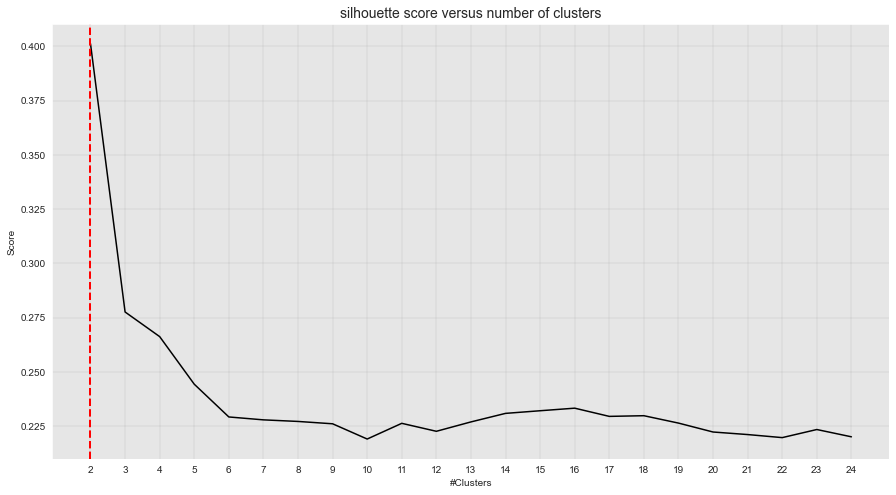

(<Figure size 1080x576 with 1 Axes>,
 <AxesSubplot:title={'center':'silhouette score versus number of clusters'}, xlabel='#Clusters', ylabel='Score'>)

In [60]:
cluster_evaluation = clusteval(method='silhouette',cluster="kmeans") 
cluster_evaluation.fit(np.array(feature_data))
cluster_evaluation.plot()

### Silhouette Score 

Silhouette score refers to a method of interpretation and validation of consistency within clusters of data. The higher the score, the better the overall cluster measure, such as within-variability and between-variability of the clusters.  According to the chart (above) a `CLUSTER_SIZE = 2` is most appropriate.

# Data Reduction

More data is not always the solution.  When working with 'big data' we must consider the issues around redundancy, outliers, and storage.  Data reduction (as the name suggests) actively encourages the reduction of data, where possible, through the elimination of data-rows (numerosity), and data-columns (features).  This reduction must be weighed in against the overall quality/information that would be forfeited.

## Reasons for Reducing Data

- Increases storage capacity
- Easy and efficient Mining, reduces time and memory requirement
- Easy visualisation
- Help to eliminate irrelevant /redundant features
- Reduces noise

## Numerosity Reduction

Numerosity reduction involves the replacement of voluminous data, with an alternate, smaller form of data representation. This exchange can be achieved via parametric and non-parametric methods.

- `Parametric Numerosity Reduction` -> These techniques include linear regression and log linear models, to which the model's parameters can be stored, instead of the FULL data representation. 

- `Non-Parametric Numerosity Reduction` -> Sampling, histograms, clustering, data cube aggregation.

### Numerosity Reduction - Sampling with Decision Tree

In [61]:
dt_pipeline_1 = Pipeline([
    ("dt_classifier",DecisionTreeClassifier(random_state=RANDOM_STATE))
])
# Grid Search
param_grid = {
    'dt_classifier__criterion': ["gini", "entropy"],
    'dt_classifier__max_depth': [None] + list(range(1,len(feature_data.columns)))
}

In [62]:
sampled_learning_data = learning_data.sample(frac=0.5,random_state=RANDOM_STATE)
sampled_target_data = sampled_learning_data["is_expensive"]
sampled_feature_data = sampled_learning_data.drop("is_expensive",axis="columns")

In [63]:
dt_pipeline_1_search = GridSearchCV(dt_pipeline_1, param_grid, n_jobs=-1, cv=CROSS_VALIDATION_PARTITION)
dt_pipeline_1_search.fit(sampled_feature_data,sampled_target_data)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('dt_classifier',
                                        DecisionTreeClassifier(random_state=1))]),
             n_jobs=-1,
             param_grid={'dt_classifier__criterion': ['gini', 'entropy'],
                         'dt_classifier__max_depth': [None, 1, 2, 3, 4, 5, 6, 7,
                                                      8, 9, 10, 11, 12, 13, 14,
                                                      15, 16, 17, 18, 19]})

In [64]:
# Results in Tabular format
show_top_results(dt_pipeline_1_search)

|    |   rank_test_score |   mean_test_score | params                                                                 |
|---:|------------------:|------------------:|:-----------------------------------------------------------------------|
|  0 |                 1 |             0.928 | {'dt_classifier__criterion': 'gini', 'dt_classifier__max_depth': None} |
| 10 |                 1 |             0.928 | {'dt_classifier__criterion': 'gini', 'dt_classifier__max_depth': 10}   |
| 19 |                 1 |             0.928 | {'dt_classifier__criterion': 'gini', 'dt_classifier__max_depth': 19}   |
| 18 |                 1 |             0.928 | {'dt_classifier__criterion': 'gini', 'dt_classifier__max_depth': 18}   |
| 17 |                 1 |             0.928 | {'dt_classifier__criterion': 'gini', 'dt_classifier__max_depth': 17}   |

**Comment:** Though we see (above) a drop in `mean_test_score` by `1.2%` (which is not surprising), the amount of data needed for testing and training has been cut by `50%`.

### Numerosity Reduction - Sampling with Support Vector Machine

In [65]:
svm_pipeline_2 = Pipeline([
    ("svm_classifier",SVC())
])

# Grid Search
param_grid = {
    'svm_classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

In [66]:
svm_pipeline_2_search = GridSearchCV(svm_pipeline_2, param_grid, n_jobs=-1, cv=CROSS_VALIDATION_PARTITION)
svm_pipeline_2_search.fit(sampled_feature_data,sampled_target_data)

GridSearchCV(cv=10, estimator=Pipeline(steps=[('svm_classifier', SVC())]),
             n_jobs=-1,
             param_grid={'svm_classifier__kernel': ['linear', 'poly', 'rbf',
                                                    'sigmoid']})

In [67]:
# Results in Tabular format
show_top_results(svm_pipeline_2_search)

|    |   rank_test_score |   mean_test_score | params                                |
|---:|------------------:|------------------:|:--------------------------------------|
|  0 |                 1 |             0.982 | {'svm_classifier__kernel': 'linear'}  |
|  1 |                 2 |             0.977 | {'svm_classifier__kernel': 'poly'}    |
|  2 |                 3 |             0.974 | {'svm_classifier__kernel': 'rbf'}     |
|  3 |                 4 |             0.548 | {'svm_classifier__kernel': 'sigmoid'} |

**Comment:** (Above) Similar to the results from the numerosity reduction with the Decision Tree, we have observed an insignificant drop in accuracy from the default SVM model (accuracy of `98.95%`) to the numerosity reduced SVM model (accuracy `98.2%`).

## Attribute Reduction & Attribute Selection

Attribute reduction focuses on (no surprise) the reduction of the data's columns/attributes.  Data in a high-dimensional space will be transformed (by attribute reduction methods) into a low-dimensional space, so that this new, low-dimensional representation may retain appropriate amounts of meaningful properties (from the original data), whilst **also** heavily reducing the computational-power-requirements (storage, navigation, transformation etc).

It achieves this mainly through discovering the attributes that possess the lowest 'predictive value', i.e. they contribute little to the domain specific question or are insignificant in aiding attributes that *are* contributing.   

### Principal Component Analysis (PCA)

**Variance** -> In the field of statistics, variance is one of the most important measures, as it examines how the data varies within (internally) and inbetween (interactively) attributes.

PCA summarises the attributes of the model through linear combinations expressed as 'principal components' ('PC') that maximises the variance.  The variance contribution of the principal components (to the data) are ordered such that the first principal component is the 'most valuable' or 'highest contributory' attribute.  Furthermore, one of the requirements of PCA is that the data is scaled, as the linear combination is sensitive to (attribute value) ranges (values with large magnitude value ranges will dominate the other PCs). 

It should be noted that although PCA does a good job of multidimensional to low-dimensional data summarisation, it makes it ***very*** difficult to determine which domain specific attribute/s is the one/s contributing to the model.

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [20] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [18] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


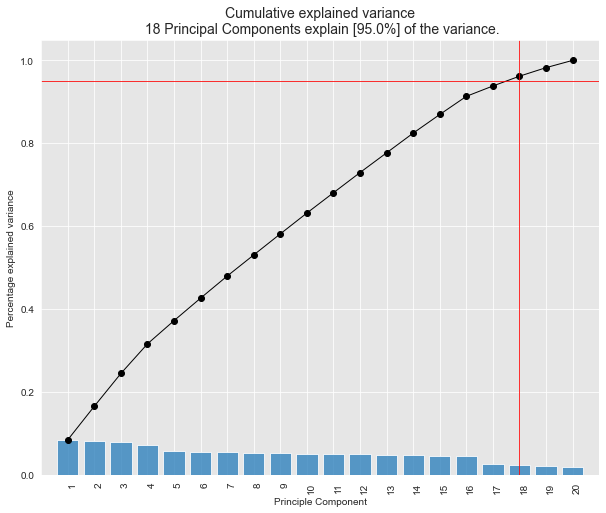

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Cumulative explained variance\n 18 Principal Components explain [95.0%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 432x288 with 0 Axes>

In [68]:
model = pca(n_components=0.95) # explains 95% of variance
scaled_data = StandardScaler().fit_transform(feature_data)
results = model.fit_transform(scaled_data)
model.plot()

**Comment:** According to the total contributions, to be able to explain 95% of the data's variance, there is a requirement to retain 18 principal components. It should be noted that this is most unusual for PCA, with most PCA's having 95% of the (data's) variance explained by only a tiny subset of the data's total dimensions.

### Attribute Reduction - Decision Tree with PCA

In [69]:
dt_pipeline_3 = Pipeline([
    ("scale", StandardScaler()),
    ("pca", PCA()),
    ("dt_classifier",DecisionTreeClassifier(random_state=RANDOM_STATE))
])
# Grid Search
param_grid = {
    'pca__n_components': range(1,len(feature_data.columns)),
    'dt_classifier__criterion': ["gini", "entropy"],
    'dt_classifier__max_depth': [None] + list(range(1,len(feature_data.columns)))
}

In [70]:
dt_pipeline_3_search = GridSearchCV(dt_pipeline_3, param_grid, n_jobs=-1, cv=CROSS_VALIDATION_PARTITION)
dt_pipeline_3_search.fit(feature_data,target_data)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('pca', PCA()),
                                       ('dt_classifier',
                                        DecisionTreeClassifier(random_state=1))]),
             n_jobs=-1,
             param_grid={'dt_classifier__criterion': ['gini', 'entropy'],
                         'dt_classifier__max_depth': [None, 1, 2, 3, 4, 5, 6, 7,
                                                      8, 9, 10, 11, 12, 13, 14,
                                                      15, 16, 17, 18, 19],
                         'pca__n_components': range(1, 20)})

In [71]:
show_top_results(dt_pipeline_3_search)

|     |   rank_test_score |   mean_test_score | params                                                                                           |
|----:|------------------:|------------------:|:-------------------------------------------------------------------------------------------------|
| 568 |                 1 |            0.8395 | {'dt_classifier__criterion': 'entropy', 'dt_classifier__max_depth': 9, 'pca__n_components': 18}  |
| 682 |                 2 |            0.8385 | {'dt_classifier__criterion': 'entropy', 'dt_classifier__max_depth': 15, 'pca__n_components': 18} |
| 566 |                 3 |            0.8385 | {'dt_classifier__criterion': 'entropy', 'dt_classifier__max_depth': 9, 'pca__n_components': 16}  |
| 567 |                 3 |            0.8385 | {'dt_classifier__criterion': 'entropy', 'dt_classifier__max_depth': 9, 'pca__n_components': 17}  |
| 663 |                 5 |            0.838  | {'dt_classifier__criterion': 'entropy', 'dt_classifier__max_depth': 14, 'pca__n_components': 18} |

In [72]:
print(f"Best Test Scores: {dt_pipeline_3_search.best_score_}")
print(f"Best Params: {dt_pipeline_3_search.best_params_}")

Best Test Scores: 0.8394999999999999
Best Params: {'dt_classifier__criterion': 'entropy', 'dt_classifier__max_depth': 9, 'pca__n_components': 18}


**Comment:** The results from our Decision Tree attribute reduction with PCA demonstrated a **significant** decrease in accuracy (from un-reduced accuracy of `94.75%`, to `83.95%`.  These results come as no surprise, as per results earlier, there is an unusual contribution to total variance of PCA.  We should also consider the possibility that the summarisation of attributes to principal components increased the impact that outliers exerted upon the (outlier sensitive) decision tree model.

### Attribute Reduction - Support Vector Machine with PCA

In [73]:
svm_pipeline_3 = Pipeline([
    ("scale", StandardScaler()),
    ("pca", PCA()),
    ("svm_classifier",SVC())
])

# Grid Search
param_grid = {
    'pca__n_components': range(1,len(feature_data.columns)),
    'svm_classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
}

In [74]:
svm_pipeline_3_search = GridSearchCV(svm_pipeline_3, param_grid, n_jobs=-1, cv=CROSS_VALIDATION_PARTITION)
svm_pipeline_3_search.fit(feature_data,target_data)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('pca', PCA()),
                                       ('svm_classifier', SVC())]),
             n_jobs=-1,
             param_grid={'pca__n_components': range(1, 20),
                         'svm_classifier__kernel': ['linear', 'poly', 'rbf',
                                                    'sigmoid', 'precomputed']})

In [75]:
show_top_results(svm_pipeline_3_search)

|    |   rank_test_score |   mean_test_score | params                                                         |
|---:|------------------:|------------------:|:---------------------------------------------------------------|
| 85 |                 1 |            0.991  | {'pca__n_components': 18, 'svm_classifier__kernel': 'linear'}  |
| 80 |                 1 |            0.991  | {'pca__n_components': 17, 'svm_classifier__kernel': 'linear'}  |
| 90 |                 3 |            0.9895 | {'pca__n_components': 19, 'svm_classifier__kernel': 'linear'}  |
| 75 |                 4 |            0.984  | {'pca__n_components': 16, 'svm_classifier__kernel': 'linear'}  |
| 88 |                 5 |            0.9785 | {'pca__n_components': 18, 'svm_classifier__kernel': 'sigmoid'} |

In [76]:
print(f"Best Test Scores: {svm_pipeline_3_search.best_score_}")
print(f"Best Params: {svm_pipeline_3_search.best_params_}")
print(f"Best CV Index: {svm_pipeline_3_search.best_index_}")

Best Test Scores: 0.991
Best Params: {'pca__n_components': 17, 'svm_classifier__kernel': 'linear'}
Best CV Index: 80


**Comment:** The results (above) show the minimal improvement in accuracy, when the SVM model undertook the attribute reduction process. SVM is more robust to noise and outliers (than Decision Trees), and so it may be possible that contrary to above, it increased the impact of the "good quality" data, rather than the outlier data. 

Prior to reduction, we observed an accuracy of `98.95%`, which then increased to `99.1%`.

## Select K-Best with Information Gain (Entropy) and ANOVA F-statistic

There are multiple ways to select the best attribute/s of a dataset, mainly through the removal of redundant (highly-corellated) or irrelevant features. The common methods include 'F-statistic', and 'Information Gain'.  F-statistic iteratively picks the attribute that *maximises* the varaiance (rather than a combination of attributes, seen in PCA).

**Information gain** measures the entropy-information available in a probability distribution. E.g :

- Skewed Probability Distribution (unsurprising) -> Low entropy.
- Balanced Probability Distribution (surprising) -> High entropy.

### Attribute Reduction - Decision Tree with Select K-Best

In [77]:
dt_pipeline_4 = Pipeline([
    ("select_kbest", SelectKBest()),
    ("dt_classifier",DecisionTreeClassifier(random_state=RANDOM_STATE))
])
# Grid Search
param_grid = {
    'select_kbest__k': range(1,len(feature_data.columns)),
    'select_kbest__score_func': [f_classif,mutual_info_classif], # F-value statistic and Information Gain (entropy)
    'dt_classifier__criterion': ["entropy"], # - Entropy is better than GINI from previous results
    'dt_classifier__max_depth': [None] + list(range(1,len(feature_data.columns)))
}

In [78]:
dt_pipeline_4_search = GridSearchCV(dt_pipeline_4, param_grid, n_jobs=-1, cv=CROSS_VALIDATION_PARTITION)
dt_pipeline_4_search.fit(feature_data,target_data)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('select_kbest', SelectKBest()),
                                       ('dt_classifier',
                                        DecisionTreeClassifier(random_state=1))]),
             n_jobs=-1,
             param_grid={'dt_classifier__criterion': ['entropy'],
                         'dt_classifier__max_depth': [None, 1, 2, 3, 4, 5, 6, 7,
                                                      8, 9, 10, 11, 12, 13, 14,
                                                      15, 16, 17, 18, 19],
                         'select_kbest__k': range(1, 20),
                         'select_kbest__score_func': [<function f_classif at 0x0000027B4261E5E0>,
                                                      <function mutual_info_classif at 0x0000027B426363A0>]})

In [79]:
show_top_results(dt_pipeline_4_search)

|     |   rank_test_score |   mean_test_score | params                                                                                                                                                                |
|----:|------------------:|------------------:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 332 |                 1 |            0.9515 | {'dt_classifier__criterion': 'entropy', 'dt_classifier__max_depth': 8, 'select_kbest__k': 15, 'select_kbest__score_func': <function f_classif at 0x0000027B4261E5E0>} |
| 260 |                 2 |            0.9515 | {'dt_classifier__criterion': 'entropy', 'dt_classifier__max_depth': 6, 'select_kbest__k': 17, 'select_kbest__score_func': <function f_classif at 0x0000027B4261E5E0>} |
| 256 |                 2 |            0.9515 | {'dt_classifier__criterion': 'entropy', 'dt_classifier__max_depth': 6, 'select_kbest__k': 15, 'select_kbest__score_func': <function f_classif at 0x0000027B4261E5E0>} |
| 250 |                 2 |            0.9515 | {'dt_classifier__criterion': 'entropy', 'dt_classifier__max_depth': 6, 'select_kbest__k': 12, 'select_kbest__score_func': <function f_classif at 0x0000027B4261E5E0>} |
| 336 |                 5 |            0.951  | {'dt_classifier__criterion': 'entropy', 'dt_classifier__max_depth': 8, 'select_kbest__k': 17, 'select_kbest__score_func': <function f_classif at 0x0000027B4261E5E0>} |

In [80]:
print(f"Best Test Scores: {dt_pipeline_4_search.best_score_}")
print(f"Best Params: {dt_pipeline_4_search.best_params_}")
print(f"Best CV Index: {dt_pipeline_4_search.best_index_}")

Best Test Scores: 0.9515
Best Params: {'dt_classifier__criterion': 'entropy', 'dt_classifier__max_depth': 8, 'select_kbest__k': 15, 'select_kbest__score_func': <function f_classif at 0x0000027B4261E5E0>}
Best CV Index: 332


### Attribute Selection with F-Statistic prior to Decision Tree

Number of Attributes: 15


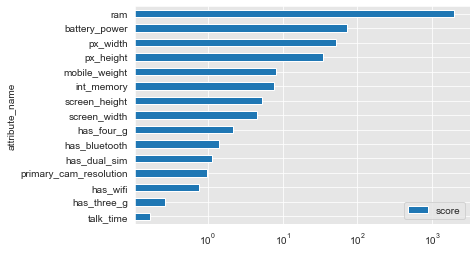

In [81]:
select_k_best = dt_pipeline_4_search.best_estimator_[0]
attributes_df = pd.DataFrame({"attribute_name": feature_data.columns[select_k_best.get_support()],"score": select_k_best.scores_[select_k_best.get_support()]})
attributes_df.sort_values("score").plot(x="attribute_name",y="score",kind="barh", logx=True)
print(f"Number of Attributes: {len(attributes_df)}")

**Comments:** The table and graph (above) display the small improvement in the accuracy percentge, when the Decision Tree model experienced the 'select k-best' attribute reduction (an increase from `94.75%` to `95.15%`).

We see the reduction method has left us with 15 attributes, in comparison to the 18 attributes in PCA.

In this scenario, it appears that F-statistic is 'better' than information gain, with regard to the transformation.  Note however, that information gain is later used for the decision tree classifier.

### Attribute Selection - With Information Gain, Prior to Decision Tree

In [82]:
dt_pipeline_4 = Pipeline([
    ("select_kbest", SelectKBest()),
    ("dt_classifier",DecisionTreeClassifier(random_state=RANDOM_STATE))
])
# Grid Search - REDUCED BECAUSE IT IS TAKING A LONG TIME
param_grid = {
    'select_kbest__k': range(10,18),
    'select_kbest__score_func': [mutual_info_classif], # F-value statistic and Information Gain (entropy)
    'dt_classifier__criterion': ["entropy"], # - Entropy is better than GINI from previous results
    'dt_classifier__max_depth': [None] + list(range(1,len(feature_data.columns)))
}

In [83]:
dt_pipeline_4_search = GridSearchCV(dt_pipeline_4, param_grid, n_jobs=-1, cv=CROSS_VALIDATION_PARTITION)
dt_pipeline_4_search.fit(feature_data,target_data)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('select_kbest', SelectKBest()),
                                       ('dt_classifier',
                                        DecisionTreeClassifier(random_state=1))]),
             n_jobs=-1,
             param_grid={'dt_classifier__criterion': ['entropy'],
                         'dt_classifier__max_depth': [None, 1, 2, 3, 4, 5, 6, 7,
                                                      8, 9, 10, 11, 12, 13, 14,
                                                      15, 16, 17, 18, 19],
                         'select_kbest__k': range(10, 18),
                         'select_kbest__score_func': [<function mutual_info_classif at 0x0000027B426363A0>]})

Number of Attributes: 10


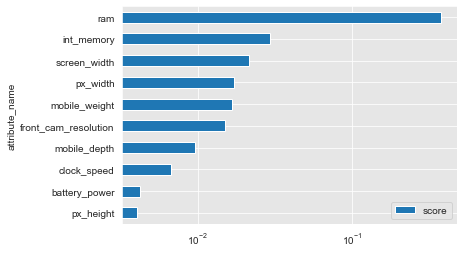

In [84]:
select_k_best = dt_pipeline_4_search.best_estimator_[0]
attributes_df = pd.DataFrame({"attribute_name": feature_data.columns[select_k_best.get_support()],"score": select_k_best.scores_[select_k_best.get_support()]})
attributes_df.sort_values("score").plot(x="attribute_name",y="score",kind="barh", logx=True)
print(f"Number of Attributes: {len(attributes_df)}")

**Comment:** The analysis above shows that F-statistic proved to be the method that makes the accuracy of the model higher (`94.90%`). This is an improvement, but not as 'good' as the improvement experienced with F-statistic.  However, for exploratory, examining the attributes there are differences in the attributes prioritised by information gain and F-statistic. 

### Attribute Reduction - Support Vector Machine with Select K-Best

In [85]:
svm_pipeline_4 = Pipeline([  
    ("select_kbest", SelectKBest()),
    ("svm_classifier",SVC())
])

# Grid Search
param_grid = {
    'select_kbest__k': range(10, 18),
    'select_kbest__score_func': [f_classif,mutual_info_classif], # F-value statistic and Information Gain (entropy)
    'svm_classifier__kernel': ['linear', 'rbf'] # removed other attributes that seems to be inaccurate
}

In [86]:
svm_pipeline_4_search = GridSearchCV(svm_pipeline_4, param_grid, n_jobs=-1, cv=CROSS_VALIDATION_PARTITION)
svm_pipeline_4_search.fit(feature_data,target_data)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('select_kbest', SelectKBest()),
                                       ('svm_classifier', SVC())]),
             n_jobs=-1,
             param_grid={'select_kbest__k': range(10, 18),
                         'select_kbest__score_func': [<function f_classif at 0x0000027B4261E5E0>,
                                                      <function mutual_info_classif at 0x0000027B426363A0>],
                         'svm_classifier__kernel': ['linear', 'rbf']})

In [87]:
show_top_results(svm_pipeline_4_search)

|    |   rank_test_score |   mean_test_score | params                                                                                                                              |
|---:|------------------:|------------------:|:------------------------------------------------------------------------------------------------------------------------------------|
|  0 |                 1 |            0.9915 | {'select_kbest__k': 10, 'select_kbest__score_func': <function f_classif at 0x0000027B4261E5E0>, 'svm_classifier__kernel': 'linear'} |
|  4 |                 1 |            0.9915 | {'select_kbest__k': 11, 'select_kbest__score_func': <function f_classif at 0x0000027B4261E5E0>, 'svm_classifier__kernel': 'linear'} |
| 12 |                 3 |            0.991  | {'select_kbest__k': 13, 'select_kbest__score_func': <function f_classif at 0x0000027B4261E5E0>, 'svm_classifier__kernel': 'linear'} |
|  8 |                 4 |            0.9905 | {'select_kbest__k': 12, 'select_kbest__score_func': <function f_classif at 0x0000027B4261E5E0>, 'svm_classifier__kernel': 'linear'} |
| 16 |                 4 |            0.9905 | {'select_kbest__k': 14, 'select_kbest__score_func': <function f_classif at 0x0000027B4261E5E0>, 'svm_classifier__kernel': 'linear'} |

In [88]:
print(f"Best Test Scores: {svm_pipeline_4_search.best_score_}")
print(f"Best Params: {svm_pipeline_4_search.best_params_}")
print(f"Best CV Index: {svm_pipeline_4_search.best_index_}")

Best Test Scores: 0.9914999999999999
Best Params: {'select_kbest__k': 10, 'select_kbest__score_func': <function f_classif at 0x0000027B4261E5E0>, 'svm_classifier__kernel': 'linear'}
Best CV Index: 0


Number of Attributes: 10


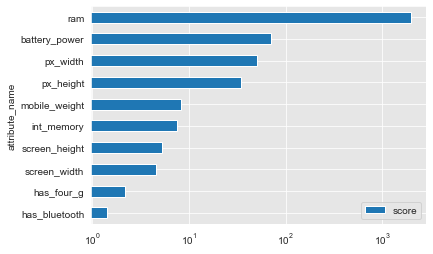

In [89]:
select_k_best = svm_pipeline_4_search.best_estimator_[0]
attributes_df = pd.DataFrame({"attribute_name": feature_data.columns[select_k_best.get_support()],"score": select_k_best.scores_[select_k_best.get_support()]})
attributes_df.sort_values("score").plot(x="attribute_name",y="score",kind="barh", logx=True)
print(f"Number of Attributes: {len(attributes_df)}")

**Comment:** The output (above) indicates a minor accuracy improvement, from `98.95%` to `99.1%`. Note that this increase is `0.04%` better than the observed accuracy for SVM, with PCA.

We also observe that the suggested best number of attributes (for SVM) from F-statistic is `10`, a notably smaller value than the suggested 'best number' of attributes from F-statistic for Decision Tree (`15`).


## Data Reduction - Conclusion

As seen in our experiments above (with our chosen measure of *classifier-accuracy* as accuracy), numerosity reduction **heavily** decreases the required data, in exchange for a small decrease in overall model accuracy.  Attribute reduction via transformation (such as PCA) is seen in varying instances to both increase / decrease the model accuracy, while attribute reduction (by selection) demonstrated an overall net increase in accuracy . Furthermore, with attribute reduction, we also observed a decrease in required model-training time.

## Attribute Selection - Manual Selection

With user-side specific domain knowledge (regarding expensive phones), we manually selected the following attributes.  Note that the accuracy of this "model" is heavily dependent on the depth of the user's domain specific knowledge.  In most real-world data science projects,  manual attribute selection (performed by subject matter experts), mitigates the possibility of over-fitting, that arises with pure criterium-based attribute selection.

For example, in electrical-engineering problems (where the voltage attribute is crucial) the data may suggest that voltage could/should be eliminated (for the purpose of increasing accuracy).  If relied upon, the resultant model has the 'best' accuracy, but it may inappropriate and/or unusable in the real world.

In [90]:
# Based on domain-specific knowledge and the exploratory plots
MANUALLY_SELECTED_ATTRIBUTES = [
    "ram",
    "has_four_g",
    "mobile_depth",
    "screen_width",
    "screen_height",
    "primary_cam_resolution",
    "number_of_cores",
    "int_memory",
    "px_width",
    "px_height"]

feature_data_manually_selected = learning_data.drop("is_expensive",axis="columns")[MANUALLY_SELECTED_ATTRIBUTES]

## Decision Tree with Manually Selected Attribute

In [91]:
dt_pipeline_1 = Pipeline([
    ("dt_classifier",DecisionTreeClassifier(random_state=RANDOM_STATE))
])
# Grid Search
param_grid = {
    'dt_classifier__criterion': ["gini", "entropy"],
    'dt_classifier__max_depth': [None] + list(range(1,len(feature_data.columns)))
}

In [92]:
dt_pipeline_1_search = GridSearchCV(dt_pipeline_1, param_grid, n_jobs=-1, cv=CROSS_VALIDATION_PARTITION)
dt_pipeline_1_search.fit(feature_data_manually_selected,target_data)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('dt_classifier',
                                        DecisionTreeClassifier(random_state=1))]),
             n_jobs=-1,
             param_grid={'dt_classifier__criterion': ['gini', 'entropy'],
                         'dt_classifier__max_depth': [None, 1, 2, 3, 4, 5, 6, 7,
                                                      8, 9, 10, 11, 12, 13, 14,
                                                      15, 16, 17, 18, 19]})

In [93]:
show_top_results(dt_pipeline_1_search)

|    |   rank_test_score |   mean_test_score | params                                                                 |
|---:|------------------:|------------------:|:-----------------------------------------------------------------------|
|  4 |                 1 |            0.9235 | {'dt_classifier__criterion': 'gini', 'dt_classifier__max_depth': 4}    |
|  2 |                 2 |            0.9215 | {'dt_classifier__criterion': 'gini', 'dt_classifier__max_depth': 2}    |
|  1 |                 2 |            0.9215 | {'dt_classifier__criterion': 'gini', 'dt_classifier__max_depth': 1}    |
|  3 |                 4 |            0.9205 | {'dt_classifier__criterion': 'gini', 'dt_classifier__max_depth': 3}    |
| 25 |                 5 |            0.9175 | {'dt_classifier__criterion': 'entropy', 'dt_classifier__max_depth': 5} |

In [94]:
print(f"Best Test Scores: {dt_pipeline_1_search.best_score_}")
print(f"Best Params: {dt_pipeline_1_search.best_params_}")

Best Test Scores: 0.9235000000000001
Best Params: {'dt_classifier__criterion': 'gini', 'dt_classifier__max_depth': 4}


**Comment:** When the Decision Tree was reduced with our manually-selected-attribute model, we note a relatively large drop in accuracy from `94.75%` to `92.35%` (`2.4%`).  

## SVM with Manually Selected Attributes

In [95]:
svm_pipeline_2 = Pipeline([
    ("svm_classifier",SVC())
])

# Grid Search
param_grid = {
    'svm_classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

In [96]:
svm_pipeline_2_search = GridSearchCV(svm_pipeline_2, param_grid, n_jobs=-1, cv=CROSS_VALIDATION_PARTITION)
svm_pipeline_2_search.fit(feature_data_manually_selected,target_data)

GridSearchCV(cv=10, estimator=Pipeline(steps=[('svm_classifier', SVC())]),
             n_jobs=-1,
             param_grid={'svm_classifier__kernel': ['linear', 'poly', 'rbf',
                                                    'sigmoid']})

In [97]:
show_top_results(svm_pipeline_2_search)

|    |   rank_test_score |   mean_test_score | params                                |
|---:|------------------:|------------------:|:--------------------------------------|
|  2 |                 1 |            0.9295 | {'svm_classifier__kernel': 'rbf'}     |
|  0 |                 2 |            0.9265 | {'svm_classifier__kernel': 'linear'}  |
|  1 |                 2 |            0.9265 | {'svm_classifier__kernel': 'poly'}    |
|  3 |                 4 |            0.519  | {'svm_classifier__kernel': 'sigmoid'} |

In [98]:
print(f"Best Test Scores: {svm_pipeline_2_search.best_score_}")
print(f"Best Params: {svm_pipeline_2_search.best_params_}")

Best Test Scores: 0.9295
Best Params: {'svm_classifier__kernel': 'rbf'}


**Comment:** When the SVM was reduced with our manually-selected-attribute model, we observe a notably large drop in accuracy from `98.95%` to `92.95%`.  This decrease in accuracy with SVM (`6.0%`) is much larger than the decrease experienced by Decision Tree.  

## Attribute Selection - Conclusion

Through our experiments, F-statistic attribute selection demonstrated the best overall accuracy for both SVM and Decision Tree, as defined by the hyperparameter grid search.

Our results would indicate that Information Gain ranks second in accuracy, increasing both SVM and DT's accuracy.  This can be contrasted with manual attribute selection, which showed poor results, with decreases in the accuracy of **both** of our classifiers. 

# <u>Appendix</u>

#### Raw Data Profiling Report

In [99]:
raw_profile = ProfileReport(raw_data, explorative=True, orange_mode=True, title="Raw Data Profiling Report")

# set the Metadata
metadata_dict = raw_metadata.to_dict()["Explaination"]

raw_profile.set_variable("variables.descriptions",metadata_dict)
raw_profile.to_file("./profile_reports/raw_data_profile.html")
# raw_profile

#### Clean Data Profiling Report

In [100]:
# Generate new pandas-profiling 
cleaned_data_profile = ProfileReport(cleaned_data, explorative=True, orange_mode=True, title="Clean Data Profiling Report")
cleaned_data_profile.set_variable("variables.descriptions",cleaned_metadata_dict) # Set Metadata                  
cleaned_data_profile.to_file("./profile_reports/cleaned_data_profile.html")
# cleaned_data_profile

C:\Users\frinz\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


#### Discretised Data Profiling Report

In [101]:
# Generate new pandas-profiling 
discretised_data_profile = ProfileReport(discretised_data, explorative=True, orange_mode=True, title="Discretised Data Profiling Report")
discretised_data_profile.set_variable("variables.descriptions",cleaned_metadata_dict) # Set Metadata                  
discretised_data_profile.to_file("./profile_reports/discretised_data_profile.html")
# discretised_data_profile

C:\Users\frinz\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
